In [11]:
import os
import numpy as np
import pandas as pd
import requests
from antropy import perm_entropy
import matplotlib.pyplot as plt
from IPython.display import display
from collections import defaultdict
import seaborn as sns


In [13]:
folder_path = 'project2_data_chest'



In [15]:
# List all files in the folder and filter for CSV files
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

print(csv_files)  # To see all the CSV files in the folder

['s5_acc_walking_walking_chest.csv', 's10_acc_climbingdown_climbingdown_chest.csv', 's10_acc_walking_walking_chest.csv', 's5_acc_climbingup_climbingup_chest.csv', 's2_acc_running_running_chest.csv', 's11_acc_climbingdown_climbingdown_chest.csv', 's13_acc_climbingup_climbingup_chest.csv', 's2_acc_walking_walking_chest.csv', 's13_acc_climbingdown_climbingdown_chest.csv', 's6_acc_climbingup_climbingup_chest.csv', 's9_acc_climbingup_climbingup_chest.csv', 's5_acc_running_running_chest.csv', 's12_acc_climbingdown_climbingdown_chest.csv', 's10_acc_running_running_chest.csv', 's10_acc_climbingup_climbingup_chest.csv', 's3_acc_climbingup_climbingup_chest.csv', 's3_acc_running_running_chest.csv', 's11_acc_walking_walking_chest.csv', 's15_acc_climbingup_climbingup_chest.csv', 's4_acc_walking_walking_chest.csv', 's11_acc_running_running_chest.csv', 's4_acc_running_running_chest.csv', 's15_acc_climbingdown_climbingdown_chest.csv', 's14_acc_climbingdown_climbingdown_chest.csv', 's3_acc_walking_walk

In [17]:
# List to hold all dataframes
dfs = []

# Loop through each file and read the CSV
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all the dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)

# Display the first few rows
print(combined_df.head())

   id      attr_time    attr_x    attr_y    attr_z
0   1  1436372950617 -0.778116  9.583391  1.340154
1   2  1436372950637 -0.778714  9.555259  1.356914
2   3  1436372950657 -0.736217  9.473856  1.403601
3   4  1436372950677 -0.697311  9.433155  1.540070
4   5  1436372950697 -0.725443  9.451710  1.594538


In [19]:
combined_df.to_csv('combined_data.csv', index=False)

In [20]:
print(df.head())  # First few rows of the data to verify the content
print(df.columns)  # List all column names to ensure they include 'subject', 'axis', 'activity'


   id      attr_time    attr_x    attr_y    attr_z
0   1  1435996968010  5.616797  8.064270  0.878073
1   2  1435996968032  5.589264  8.054693  0.869095
2   3  1435996968052  5.580884  8.060080  0.908001
3   4  1435996968073  5.588067  8.033744  0.884657
4   5  1435996968093  5.583877  8.060678  0.875679
Index(['id', 'attr_time', 'attr_x', 'attr_y', 'attr_z'], dtype='object')


In [21]:
subjects = range(1, 16)
activities = ['walking', 'running', 'climbing_up', 'climbing_down']
axes = ['x', 'y', 'z']





In [54]:
def compute_complexity(time_series, dimension, delay):
    """
    Compute complexity measure based on permutation entropy
    """
    pe = perm_entropy(time_series, order=dimension, delay=delay, normalize=True)
    # Complexity calculation (PE × (1 - PE))
    complexity = pe * (1 - pe)
    return pe, complexity

def extract_features(df, subjects, activities, axes, dimensions, delays, signal_lengths):
    """
    Extract permutation entropy and complexity features for different parameters
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input data containing the time series
    subjects : list
        List of subject IDs
    activities : list
        List of activities
    axes : list
        List of accelerometer axes
    dimensions : list
        List of embedding dimensions
    delays : list
        List of embedding delays
    signal_lengths : list
        List of signal lengths to consider
    
    Returns:
    --------
    pandas DataFrame
        Features for all combinations of parameters
    """
    results = []
    
    for subject in subjects:
        for activity in activities:
            # Filter data for current subject and activity
            subject_data = df[
                (df['subject'] == subject) & 
                (df['activity'] == activity)
            ]
            
            if len(subject_data) == 0:
                continue
                
            for axis in axes:
                time_series = subject_data[axis].values
                
                for length in signal_lengths:
                    if len(time_series) < length:
                        continue
                        
                    # Use the first 'length' points
                    ts_segment = time_series[:length]
                    
                    for dimension in dimensions:
                        for delay in delays:
                            try:
                                pe, complexity = compute_complexity(
                                    ts_segment, 
                                    dimension, 
                                    delay
                                )
                                
                                results.append({
                                    'Subject': subject,
                                    'Accelerometer_axis': axis,
                                    'Signal_length': length,
                                    'Dimension': dimension,
                                    'Delay': delay,
                                    'Permutation_entropy': pe,
                                    'Complexity': complexity,
                                    'Activity': activity
                                })
                            except Exception as e:
                                print(f"Error processing: Subject {subject}, Activity {activity}, "
                                      f"Axis {axis}, Length {length}, Dimension {dimension}, "
                                      f"Delay {delay}")
                                print(f"Error: {str(e)}")
    
    return pd.DataFrame(results)

In [56]:
print(combined_df.shape)

(1752359, 5)


In [58]:
print(combined_df.columns)

Index(['id', 'attr_time', 'attr_x', 'attr_y', 'attr_z'], dtype='object')


In [60]:
print(combined_df.head())

   id      attr_time    attr_x   attr_y   attr_z
0   1  1436372950617 -0.778116 9.583391 1.340154
1   2  1436372950637 -0.778714 9.555259 1.356914
2   3  1436372950657 -0.736217 9.473856 1.403601
3   4  1436372950677 -0.697311 9.433155 1.540070
4   5  1436372950697 -0.725443 9.451710 1.594538


In [62]:
def compute_features(time_series, dimensions, delays, signal_lengths):
    """
    Computing permutation entropy and complexity for a single time series
    """
    results = []
    
    for length in signal_lengths:
        if len(time_series) < length:
            continue
            
        ts_segment = time_series[:length]
        
        for dimension in dimensions:
            for delay in delays:
                try:
                    pe = perm_entropy(ts_segment, order=dimension, delay=delay, normalize=True)
                    complexity = pe * (1 - pe)
                    
                    results.append({
                        'Signal_length': length,
                        'Dimension': dimension,
                        'Delay': delay,
                        'Permutation_entropy': round(pe, 6),
                        'Complexity': round(complexity, 6)
                    })
                except Exception as e:
                    print(f"Error processing: Length {length}, Dimension {dimension}, Delay {delay}")
                    print(f"Error: {str(e)}")
    
    return results

# Parameters
dimensions = [3, 4, 5, 6]
delays = [1, 2, 3]
signal_lengths = [1024, 2048, 4096]
folder_path = 'project2_data_chest'

# Activity mapping for filename to standardized name
activity_map = {
    'walking': 'walking',
    'running': 'running',
    'climbingup': 'climbing_up',
    'climbingdown': 'climbing_down'
}

# Initialize results
all_results = []

# Process each file
for filename in os.listdir(folder_path):
    if not filename.endswith('_chest.csv'):
        continue
        
    # Extracting the  subject and activity from filename
    parts = filename.split('_')
    subject = int(parts[0][1:])  # Remove 's' and convert to int
    activity = activity_map[parts[2]]  # Map to standardized activity name
    
    # Loading the  data
    file_path = os.path.join(folder_path, filename)
    df = pd.read_csv(file_path)
    
    # Process each axis
    for axis in ['x', 'y', 'z']:
        column_name = f'attr_{axis}'
        if column_name not in df.columns:
            print(f"Warning: {column_name} not found in {filename}")
            continue
            
        time_series = df[column_name].values
        features = compute_features(time_series, dimensions, delays, signal_lengths)
        
        # Adding subject, activity, and axis information
        for result in features:
            result.update({
                'Subject': subject,
                'Accelerometer_axis': axis,
                'Activity': activity
            })
            all_results.append(result)
        
        print(f"Processed {filename} - {axis} axis")

# Creating DataFrame and clean up
results_df = pd.DataFrame(all_results)

# Reordering  columns
column_order = [
    'Subject', 
    'Accelerometer_axis', 
    'Signal_length', 
    'Dimension', 
    'Delay', 
    'Permutation_entropy', 
    'Complexity', 
    'Activity'
]
results_df = results_df[column_order]

# Displaying  results with better formatting
pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)



# Saving the  results
results_df.to_csv('feature_extraction_results.csv', index=False)

# Verify we have all expected combinations
print("\nVerification counts:")
print(f"Number of subjects: {results_df['Subject'].nunique()}")
print(f"Number of activities: {results_df['Activity'].nunique()}")
print(f"Number of signal lengths: {results_df['Signal_length'].nunique()}")
print(f"Number of dimensions: {results_df['Dimension'].nunique()}")
print(f"Number of delays: {results_df['Delay'].nunique()}")

Processed s5_acc_walking_walking_chest.csv - x axis
Processed s5_acc_walking_walking_chest.csv - y axis
Processed s5_acc_walking_walking_chest.csv - z axis
Processed s10_acc_climbingdown_climbingdown_chest.csv - x axis
Processed s10_acc_climbingdown_climbingdown_chest.csv - y axis
Processed s10_acc_climbingdown_climbingdown_chest.csv - z axis
Processed s10_acc_walking_walking_chest.csv - x axis
Processed s10_acc_walking_walking_chest.csv - y axis
Processed s10_acc_walking_walking_chest.csv - z axis
Processed s5_acc_climbingup_climbingup_chest.csv - x axis
Processed s5_acc_climbingup_climbingup_chest.csv - y axis
Processed s5_acc_climbingup_climbingup_chest.csv - z axis
Processed s2_acc_running_running_chest.csv - x axis
Processed s2_acc_running_running_chest.csv - y axis
Processed s2_acc_running_running_chest.csv - z axis
Processed s11_acc_climbingdown_climbingdown_chest.csv - x axis
Processed s11_acc_climbingdown_climbingdown_chest.csv - y axis
Processed s11_acc_climbingdown_climbingd

In [64]:
print(f"\nShape of results: {results_df.shape}")
print("\nFirst few rows:")
print(results_df.head(10))


Shape of results: (6480, 8)

First few rows:
   Subject Accelerometer_axis  Signal_length  Dimension  Delay  \
0        5                  x           1024          3      1   
1        5                  x           1024          3      2   
2        5                  x           1024          3      3   
3        5                  x           1024          4      1   
4        5                  x           1024          4      2   
5        5                  x           1024          4      3   
6        5                  x           1024          5      1   
7        5                  x           1024          5      2   
8        5                  x           1024          5      3   
9        5                  x           1024          6      1   

   Permutation_entropy  Complexity Activity  
0             0.908688    0.082974  walking  
1             0.959691    0.038684  walking  
2             0.976035    0.023391  walking  
3             0.859659    0.120645  walking

In [66]:
# selecting a single subject, accelerometer axis, and signal length to focus our analysis
subject = 3        # Subject #3 was chosen for this analysis
axis = 'x'         # We'll analyze the x-axis accelerometer data
signal_length = 1024  # Using a signal length of 1024 data points

# Apply filtering to the results dataframe to get only the data we're interested in
filtered_data = results_df[
    (results_df['Subject'] == subject) & 
    (results_df['Accelerometer_axis'] == axis) & 
    (results_df['Signal_length'] == signal_length)
]


In [68]:
# Display information about our filtered dataset
print(f"Filtered data for Subject {subject}, {axis}-axis, Signal length {signal_length}:")
print(f"Shape: {filtered_data.shape}")  # Shows how many rows and columns we have after filtering
display(filtered_data.head())  # Display the first few rows to see what our data looks like


Filtered data for Subject 3, x-axis, Signal length 1024:
Shape: (48, 8)


,Subject,Accelerometer_axis,Signal_length,Dimension,Delay,Permutation_entropy,Complexity,Activity
1620,3,x,1024,3,1,0.895234,0.093790,climbing_up
1621,3,x,1024,3,2,0.953425,0.044405,climbing_up
1622,3,x,1024,3,3,0.949489,0.047959,climbing_up
1623,3,x,1024,4,1,0.843563,0.131965,climbing_up
1624,3,x,1024,4,2,0.916188,0.076787,climbing_up


                              Analysis Summary: 
We analyzed Subject 3's x-axis accelerometer data with a signal length of 1024 data points.
We identified the optimal embedding dimension and delay for distinguishing between activities.
The scatter plots show that different parameter combinations create varying degrees of separation.
The optimal parameters provide the maximum separation between activity classes,
which is essential for accurate activity classification and recognition.

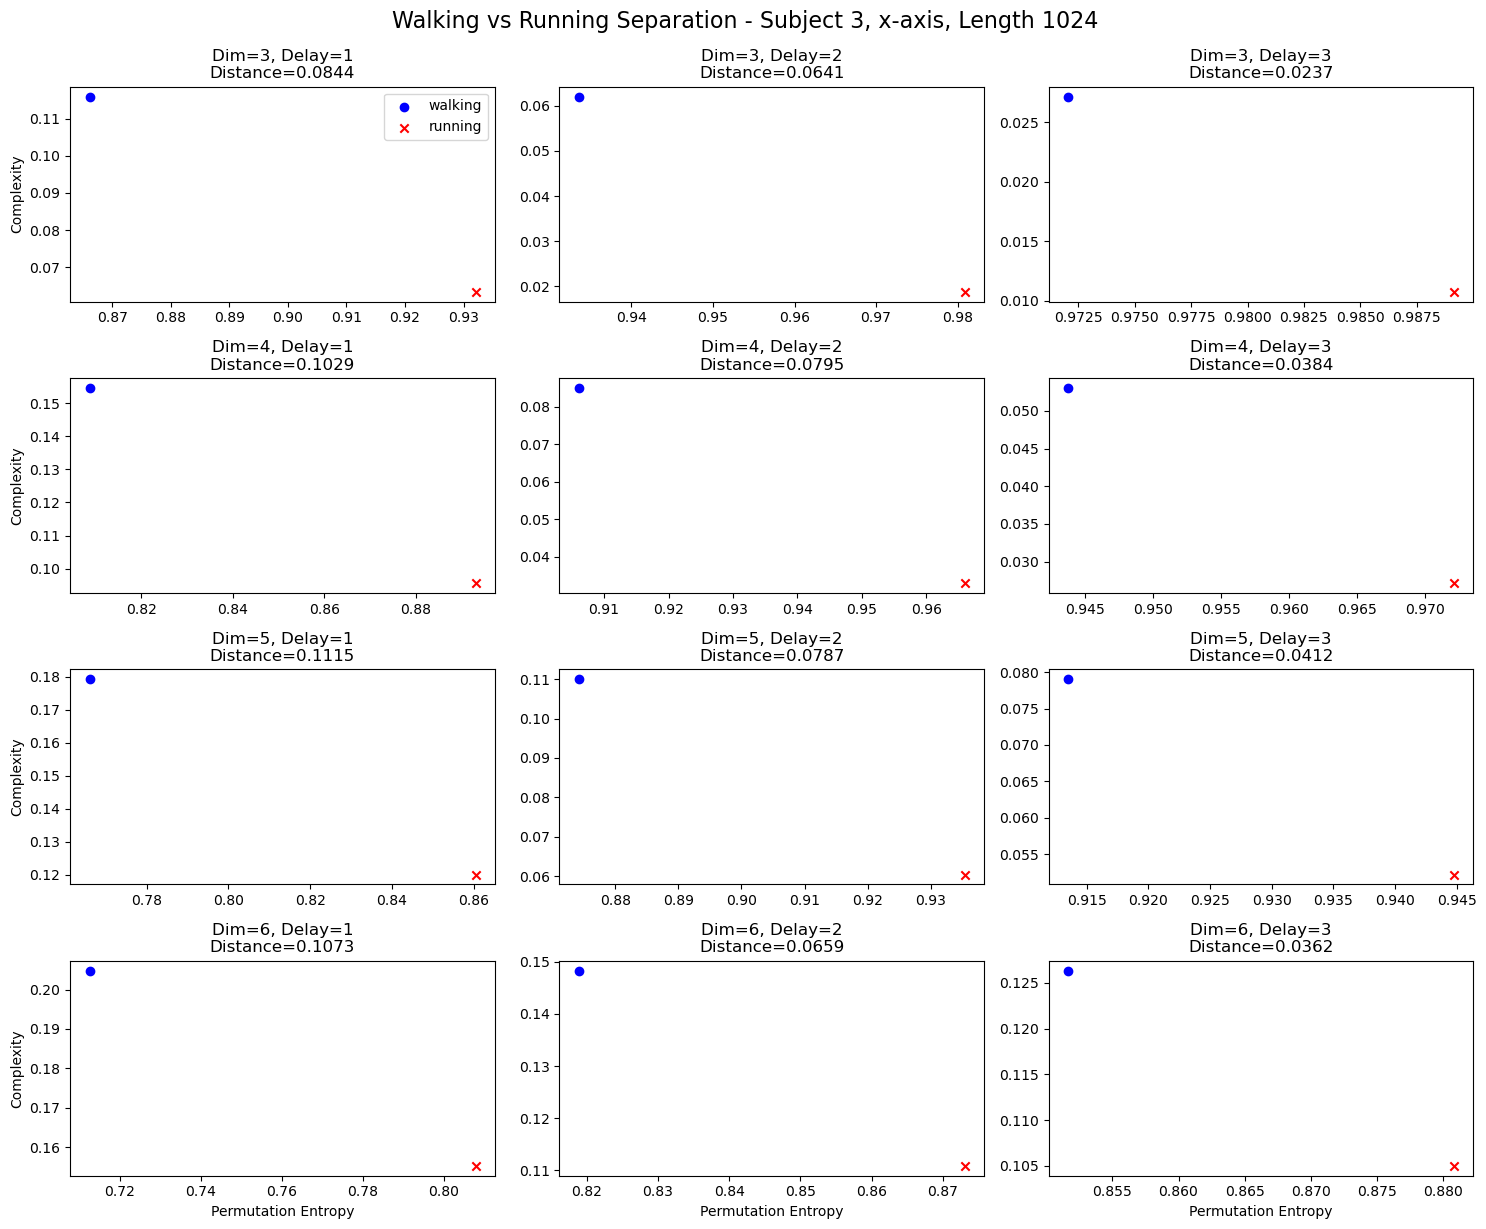

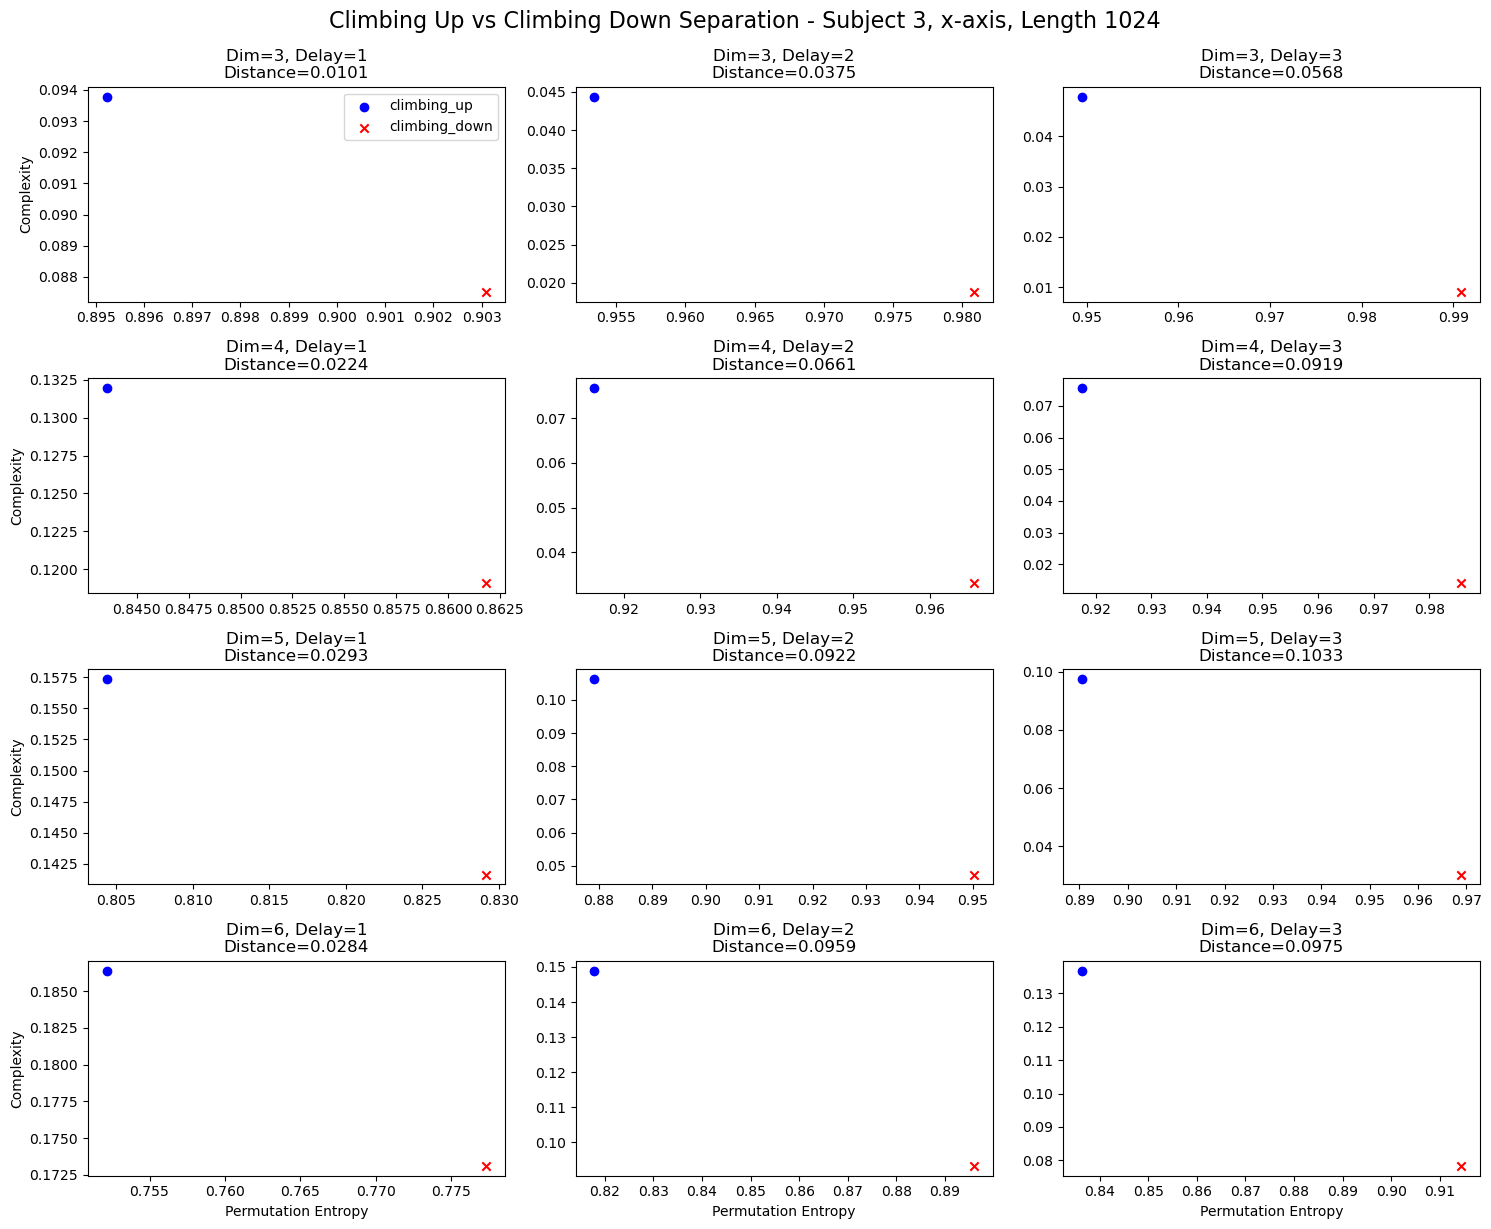


Creating summary visualizations for the optimal parameters:


In [72]:
# We want to compare these two activities specifically
walk_run_data = filtered_data[filtered_data['Activity'].isin(['walking', 'running'])]

# Define a function to create scatter plots for all dimension-delay combinations
# This helps us visualize how well different parameter combinations separate activities
def plot_activity_separation(data, activity1, activity2, title_prefix):
    """
    Creates a grid of scatter plots showing how different dimension and delay parameters
    affect the separation between two activities in the permutation entropy vs complexity space.
    
    Parameters:
    -----------
    data : pandas DataFrame
        The filtered dataset containing both activities
    activity1, activity2 : str
        Names of the two activities to compare
    title_prefix : str
        Title to display above the entire plot grid
    """
    # Create a large figure to hold all subplots
    plt.figure(figsize=(15, 12))
    
    # Get all unique dimension and delay values from our data
    dimensions = sorted(data['Dimension'].unique())
    delays = sorted(data['Delay'].unique())
    
    # Calculate how many rows and columns we need for our subplot grid
    n_rows = len(dimensions)
    n_cols = len(delays)
    
    # Create each subplot - one for each dimension-delay combination
    for i, dim in enumerate(dimensions):
        for j, delay in enumerate(delays):
            # Calculate the position of this subplot in the grid
            plot_idx = i * n_cols + j + 1
            
            # Filter data for just this specific dimension and delay
            subset = data[(data['Dimension'] == dim) & (data['Delay'] == delay)]
            
            # Split the data by activity
            act1_data = subset[subset['Activity'] == activity1]
            act2_data = subset[subset['Activity'] == activity2]
            
            # Create the subplot at the calculated position
            plt.subplot(n_rows, n_cols, plot_idx)
            
            # Plot the first activity's data points (blue circles)
            plt.scatter(
                act1_data['Permutation_entropy'], 
                act1_data['Complexity'], 
                label=activity1, 
                color='blue',
                marker='o'
            )
            
            # Plot the second activity's data points (red x's)
            plt.scatter(
                act2_data['Permutation_entropy'], 
                act2_data['Complexity'], 
                label=activity2, 
                color='red',
                marker='x'
            )
            
            # Calculate the centroids (average points) for each activity cluster
            centroid1 = [act1_data['Permutation_entropy'].mean(), act1_data['Complexity'].mean()]
            centroid2 = [act2_data['Permutation_entropy'].mean(), act2_data['Complexity'].mean()]
            
            # Calculate the Euclidean distance between centroids
            # This distance represents how well-separated the activities are
            # Higher distance means better separation
            distance = ((centroid1[0] - centroid2[0])**2 + (centroid1[1] - centroid2[1])**2)**0.5
            
            # Add a title to this subplot showing the parameters and distance
            plt.title(f"Dim={dim}, Delay={delay}\nDistance={distance:.4f}")
            
            # Add axis labels only where needed (bottom row and leftmost column)
            if i == n_rows-1:  # Bottom row
                plt.xlabel('Permutation Entropy')
            if j == 0:  # Leftmost column
                plt.ylabel('Complexity')
            
            # Add a legend only to the first subplot to avoid repetition
            if i == 0 and j == 0:
                plt.legend()
    
    # Adjust spacing between subplots for better appearance
    plt.tight_layout()
    
    # Add a main title for the entire figure
    plt.suptitle(f"{title_prefix} - Subject {subject}, {axis}-axis, Length {signal_length}", 
                 fontsize=16, y=1.02)
    
    # Display the figure
    plt.show()

# Step 3: Generate walking vs running separation plots
"""
  Walking vs Running Separation Analysis:
These plots will show how well different parameter combinations separate walking from running activities.
Each plot shows permutation entropy vs complexity, with blue circles for walking and red x's for running.
The distance value shows how far apart the activity centroids are - higher is better. 
"""

plot_activity_separation(
    walk_run_data, 
    'walking', 
    'running', 
    'Walking vs Running Separation'
)

# Step 4: Analysis for climbing activities
"""
 Climbing Up vs Climbing Down Separation Analysis:")
Similar to the previous analysis, but comparing climbing up vs climbing down activities.
We are looking for which parameter combinations best distinguish these two activities.
"""
# Filter for only climbing activities
climb_data = filtered_data[filtered_data['Activity'].isin(['climbing_up', 'climbing_down'])]
# Create the plots
plot_activity_separation(
    climb_data, 
    'climbing_up', 
    'climbing_down', 
    'Climbing Up vs Climbing Down Separation'
)

# Step 5: Define a function to find the optimal parameters mathematically
def find_optimal_parameters(data, activity1, activity2):
    """
    Determines which dimension and delay combination provides the best separation
    between two activities based on the Euclidean distance between their centroids.
    
    Parameters:
    -----------
    data : pandas DataFrame
        Filtered data containing both activities
    activity1, activity2 : str
        Names of the two activities to compare
        
    Returns:
    --------
    dict
        Contains the optimal dimension, delay, and the corresponding distance
    """
    # Initialize a list to store results for all parameter combinations
    results = []
    
    # Get all unique dimensions and delays from our data
    dimensions = sorted(data['Dimension'].unique())
    delays = sorted(data['Delay'].unique())
    
    # Check each combination of dimension and delay
    for dim in dimensions:
        for delay in delays:
            # Filter data for just this specific dimension and delay
            subset = data[(data['Dimension'] == dim) & (data['Delay'] == delay)]
            
            # Split the data by activity
            act1_data = subset[subset['Activity'] == activity1]
            act2_data = subset[subset['Activity'] == activity2]
            
            # Calculate the centroids (average points) for each activity
            centroid1 = [act1_data['Permutation_entropy'].mean(), act1_data['Complexity'].mean()]
            centroid2 = [act2_data['Permutation_entropy'].mean(), act2_data['Complexity'].mean()]
            
            # Calculate the Euclidean distance between centroids
            # This is our measure of separation - higher is better
            distance = ((centroid1[0] - centroid2[0])**2 + (centroid1[1] - centroid2[1])**2)**0.5
            
            # Store these results
            results.append({
                'dimension': dim,
                'delay': delay,
                'distance': distance
            })
    
    # Find the combination with the highest distance (best separation)
    results_sorted = sorted(results, key=lambda x: x['distance'], reverse=True)
    return results_sorted[0]  # Return the best combination

# Step 6: Find and display the optimal parameters for each activity comparison
"""
Finding optimal parameters for activity separation:")
We'll calculate the Euclidean distance between activity centroids for all parameter combinations
and identify which parameters provide the best separation.
"""

# Find optimal parameters for walking vs running
walk_run_optimal = find_optimal_parameters(walk_run_data, 'walking', 'running')
# Find optimal parameters for climbing up vs climbing down
climb_optimal = find_optimal_parameters(climb_data, 'climbing_up', 'climbing_down')

# Display the results
"""
Optimal parameters for walking vs running separation
Dimension: {walk_run_optimal['dimension']}"
Delay: {walk_run_optimal['delay']}")
Distance: {walk_run_optimal['distance']
"""

# Step 7: Create visualizations to summarize the optimal parameters
print("\nCreating summary visualizations for the optimal parameters:")

# Set up data for bar plots
activities = ['Walking vs Running', 'Climbing Up vs Down']
optimal_dims = [walk_run_optimal['dimension'], climb_optimal['dimension']]
optimal_delays = [walk_run_optimal['delay'], climb_optimal['delay']]
distances = [walk_run_optimal['distance'], climb_optimal['distance']]





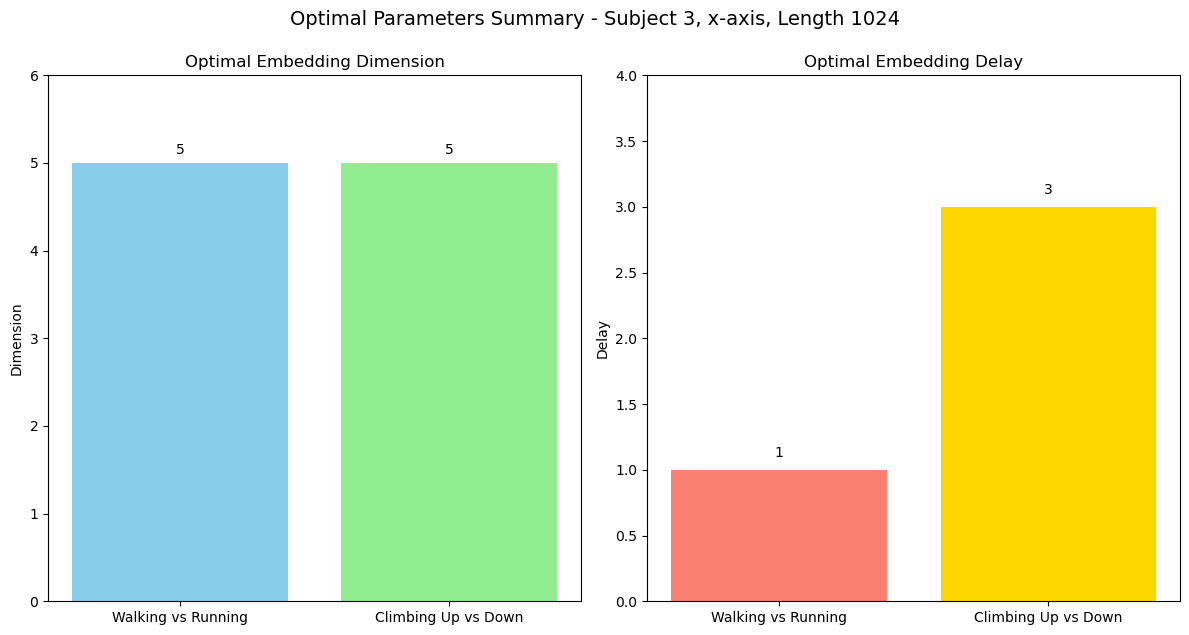

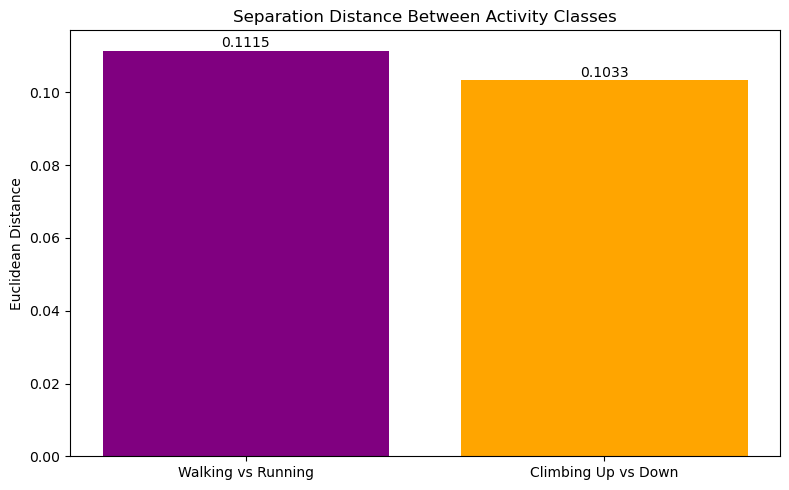

In [48]:
# Create a figure with two bar charts side by side
plt.figure(figsize=(12, 6))

# First bar chart: Optimal dimensions
plt.subplot(1, 2, 1)
plt.bar(activities, optimal_dims, color=['skyblue', 'lightgreen'])
plt.title('Optimal Embedding Dimension')
plt.ylabel('Dimension')
plt.ylim(0, max(optimal_dims) + 1)  # Set y-axis limit with some padding
# Add text labels on top of each bar
for i, v in enumerate(optimal_dims):
    plt.text(i, v + 0.1, str(v), ha='center')

# Second bar chart: Optimal delays
plt.subplot(1, 2, 2)
plt.bar(activities, optimal_delays, color=['salmon', 'gold'])
plt.title('Optimal Embedding Delay')
plt.ylabel('Delay')
plt.ylim(0, max(optimal_delays) + 1)  # Set y-axis limit with some padding
# Add text labels on top of each bar
for i, v in enumerate(optimal_delays):
    plt.text(i, v + 0.1, str(v), ha='center')

# Adjust layout and add a title
plt.tight_layout()
plt.suptitle(f'Optimal Parameters Summary - Subject {subject}, {axis}-axis, Length {signal_length}', 
             fontsize=14, y=1.05)
plt.show()

# Create a bar chart visualizing the separation distances
plt.figure(figsize=(8, 5))
plt.bar(activities, distances, color=['purple', 'orange'])
plt.title('Separation Distance Between Activity Classes')
plt.ylabel('Euclidean Distance')
# Add text labels on top of each bar showing the exact distance value
for i, v in enumerate(distances):
    plt.text(i, v + 0.001, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()
